In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from numpy.core.fromnumeric import squeeze
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_validate
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression 
from sklearn.feature_selection import f_classif, mutual_info_classif, f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.metrics import make_scorer
from imblearn.metrics import macro_averaged_mean_absolute_error
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

In [17]:
#importo il dataset
df = pd.read_csv('data_football_ratings.csv')

In [18]:
#differenziare tra centrocampisti centrali (MF) e i centrocampisti difensivi (DMF) e i centrocampisti offensivi (AMF)
df.loc[df.pos_role == 'DMC', 'pos'] = 'DMF'
df.loc[df.pos_role == 'DMR', 'pos'] = 'DMF'
df.loc[df.pos_role == 'DML', 'pos'] = 'DMF'

df.loc[df.pos_role == 'AMC', 'pos'] = 'AMF'
df.loc[df.pos_role == 'AMR', 'pos'] = 'AMF'
df.loc[df.pos_role == 'AML', 'pos'] = 'AMF'

In [19]:
#in pos, al posto di Sub metto "nan", in questo modo poi quando si fa la media, la funzione mode() non considera "Sub" come un ruolo, ma scarta direttamente i nan, non li considera
df.loc[df.pos == 'Sub','pos'] = np.nan

#per ogni calciatore calcolo la moda delle loro posizioni, in modo da assegnare la posizione alle istanze che non ce l'hanno, che hanno 'Sub' invece che la loro vera posizione
#creo un altro dataframe in cui abbiamo calciatore e la loro posizione, calcolata condiserando la loro posizione che è occorsa più volte nel dataset (moda)
df_reduced = df.groupby('player').pos.agg(pd.Series.mode).to_frame('moda_pos').reset_index()

#elimino tutte le istanze per cui non si è potuto stabilire una moda (erano tutti Sub/nan) o una moda univoca (c'erano 1 MF e 1 DF)
df_reduced.drop([9,12,21,22,37,39,44,51,52,56,67,68,78,90,92,101,119,125,129,135,142,149,164,170,176,177,179,180,182,189,207,217,227,235,239,245,257,258,259,266,272,294,301,310,313,321,323,338,351,371,384,394,402,403,414,415,423,438,444,445,453,457,467,473,475,480,489,491,501,504,515,516,531,538,550,578,583,584,602,603,604,616,621,628,630,636,643,645,664,678,684,695,702,713,719,734,738,745,757,761,762,766,785,790,791,795,809,812,825,836,844,850,854,871,879,891,897,898,899,911,916,919,923,928,929,933,937,942,945,982,994,999,1017,1040,1043,1048,1058,1060,1070,1082,1084,1091,1093,1095,1099,1106,1114,1117,1122,1130,1138,1140,1141,1144,1163,1165,1175,1191,1194,1198,1203,1203,1208,1210,1213,1214,1222,1229,1246,1253,1259,1265,1267,1281,1287,1288,1292,1293,1312,1328,1330,1346,1348,1368,1373,1375,1414,1415,1418,1421,1422,1430,1431,1433,1437,1440,1444,1446,1459,1464,1478,1495,1526,1531,1533,1535,1537,1576,1588,1603,1617], inplace= True)

df_reduced.loc[df_reduced.player =='Diafra Sakho','moda_pos'] = 'FW'
df_reduced.loc[df_reduced.player =='Julien Ngoy','moda_pos'] = 'FW'
df_reduced.loc[df_reduced.player =='Carlos Sanchez','moda_pos'] = 'MF'
df_reduced.loc[df_reduced.player =='Christoph Janker','moda_pos'] = 'DF'
df_reduced.loc[df_reduced.player =='Riechedly Bazoer','moda_pos'] = 'MF'
df_reduced.loc[df_reduced.player =='Sebastian Maier','moda_pos'] = 'MF'

#join tra df e reduced_df in modo da aggiungere a ogni (tutti) calciatore la sua posizione "preferita" e allo stesso tempo elimino le istanze dove pos == 'Sub' 
#ma non era possibile stabilire la posizione perchè non compariva mai per quel calciatore oppure a causa di una moda non unica
df_merged = pd.merge(df,df_reduced, on = 'player')

#riempio i NaN in 'pos' con la posizione di quel calciatore
df_merged.loc[df_merged.pos_role == 'Sub','pos'] = df_merged.moda_pos

#creo una colonna "starter", utilizzando l'informazione di pos_role. Starter=1 significa che è partito titolare, 0 se subentrato
fill_starter = lambda x: 0 if x == 'Sub' else 1
df_merged['starter'] = df_merged.pos_role.apply(fill_starter)

In [20]:
#cambio l'ordine dei rating tedeschi in modo che vadano in ordine crescente da 1 a 6: 6 best performance
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 1), 'original_rating'] = 'a'
df_merged.loc[(df_merged.rater == 'Kicker') & (df_merged.original_rating == 1.5), 'original_rating'] = 'b'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 2), 'original_rating'] = 'c'
df_merged.loc[(df_merged.rater == 'Kicker') & (df_merged.original_rating == 2.5), 'original_rating'] = 'd'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 3), 'original_rating'] = 'e'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 4), 'original_rating'] = 'f'
df_merged.loc[(df_merged.rater == 'Kicker') & (df_merged.original_rating == 4.5), 'original_rating'] = 'g'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 5), 'original_rating'] = 'h'
df_merged.loc[(df_merged.rater == 'Kicker') & (df_merged.original_rating == 5.5), 'original_rating'] = 'i'
df_merged.loc[((df_merged.rater == 'Kicker')|(df_merged.rater == 'Bild') ) & (df_merged.original_rating == 6), 'original_rating'] = 'l'


df_merged.loc[df_merged.original_rating == 'a', 'original_rating'] = 6
df_merged.loc[df_merged.original_rating == 'b', 'original_rating'] = 5.5
df_merged.loc[df_merged.original_rating == 'c', 'original_rating'] = 5
df_merged.loc[df_merged.original_rating == 'd', 'original_rating'] = 4.5
df_merged.loc[df_merged.original_rating == 'e', 'original_rating'] = 4
df_merged.loc[df_merged.original_rating == 'f', 'original_rating'] = 3
df_merged.loc[df_merged.original_rating == 'g', 'original_rating'] = 2.5
df_merged.loc[df_merged.original_rating == 'h', 'original_rating'] = 2
df_merged.loc[df_merged.original_rating == 'i', 'original_rating'] = 1.5
df_merged.loc[df_merged.original_rating == 'l', 'original_rating'] = 1


In [21]:
df_merged = df_merged.assign(rating=pd.Series(np.random.randn(49700)).values)

In [22]:
#Kicker
df_merged.loc[(df_merged.original_rating <= 2) & (df_merged.rater == 'Kicker'),'rating'] = 1
df_merged.loc[(df_merged.original_rating > 2) & (df_merged.original_rating <= 3) & (df_merged.rater == 'Kicker'),'rating'] = 2
df_merged.loc[(df_merged.original_rating > 3) & (df_merged.original_rating <= 4) & (df_merged.rater == 'Kicker'),'rating'] = 3
df_merged.loc[(df_merged.original_rating > 4) & (df_merged.original_rating <= 5) & (df_merged.rater == 'Kicker'),'rating'] = 4
df_merged.loc[(df_merged.original_rating > 5) & (df_merged.rater == 'Kicker'),'rating'] = 5

#Bild resta uguale
#df_merged.loc[df_merged.rater == 'Bild','rating'] = df_merged.original_rating

df_merged.loc[(df_merged.original_rating <= 2) & (df_merged.rater == 'Bild'),'rating'] = 1
df_merged.loc[(df_merged.original_rating > 2) & (df_merged.original_rating <=3) & (df_merged.rater == 'Bild'),'rating'] = 2
df_merged.loc[(df_merged.original_rating > 3) & (df_merged.original_rating <= 4) & (df_merged.rater == 'Bild'),'rating'] = 3
df_merged.loc[(df_merged.original_rating > 4) & (df_merged.original_rating <=5) & (df_merged.rater == 'Bild'),'rating'] = 4
df_merged.loc[(df_merged.original_rating > 5) & (df_merged.rater == 'Bild'),'rating'] = 5

#SKYSPORTS e THEGUARDIAN
df_merged.loc[(df_merged.original_rating <= 4) & ((df_merged.rater == 'SkySports') | (df_merged.rater == 'TheGuardian')),'rating'] = 1
df_merged.loc[(df_merged.original_rating == 5) & ((df_merged.rater == 'SkySports') | (df_merged.rater == 'TheGuardian')),'rating'] = 2
df_merged.loc[(df_merged.original_rating == 6) & ((df_merged.rater == 'SkySports') | (df_merged.rater == 'TheGuardian')),'rating'] = 3
df_merged.loc[(df_merged.original_rating == 7) & ((df_merged.rater == 'SkySports') | (df_merged.rater == 'TheGuardian')),'rating'] = 4
df_merged.loc[(df_merged.original_rating >= 8) & ((df_merged.rater == 'SkySports') | (df_merged.rater == 'TheGuardian')),'rating'] = 5

#WHOSCORED E SOFASCORE
df_merged.loc[(df_merged.original_rating < 5.5) & ((df_merged.rater == 'WhoScored') | (df_merged.rater == 'SofaScore')),'rating'] = 1
df_merged.loc[((df_merged.original_rating >= 5.5) & (df_merged.original_rating < 6.8)) & ((df_merged.rater == 'WhoScored') | (df_merged.rater == 'SofaScore')),'rating'] = 2
df_merged.loc[((df_merged.original_rating >= 6.8) & (df_merged.original_rating < 7.8)) & ((df_merged.rater == 'WhoScored') | (df_merged.rater == 'SofaScore')),'rating'] = 3
df_merged.loc[((df_merged.original_rating >= 7.8) & (df_merged.original_rating < 8.8)) & ((df_merged.rater == 'WhoScored') | (df_merged.rater == 'SofaScore')),'rating'] = 4
df_merged.loc[(df_merged.original_rating >= 8.8) & ((df_merged.rater == 'WhoScored') | (df_merged.rater == 'SofaScore')),'rating'] = 5



In [23]:
df_merged.drop([13438], axis=0, inplace=True)

df_merged.rating.value_counts()

3.0    19345
2.0    18587
4.0     7502
1.0     2633
5.0     1632
Name: rating, dtype: int64

In [24]:
#unisco i dataframe in uno
df_def = df_merged


In [25]:
df_def.rating.value_counts()

3.0    19345
2.0    18587
4.0     7502
1.0     2633
5.0     1632
Name: rating, dtype: int64

In [26]:
df_def = df_def.drop(columns= ['rater', 'is_human','original_rating'])


In [27]:
df_wod = df_def.drop_duplicates()
df_wod.rating.value_counts()

3.0    13021
2.0    12946
4.0     5865
1.0     2011
5.0     1300
Name: rating, dtype: int64

In [28]:
df_grouped = df_wod.groupby(['date','team','player']).filter(lambda g: len(g) > 1).groupby(['date','team','player']).size().to_frame('num_ratings')

In [29]:
df_merged2 = pd.merge(df_wod,df_grouped, on =['date','team','player'], how='outer')

df_merged2 = df_merged2[df_merged2.num_ratings.isna()]

df = df_merged2.drop(columns = ['competition','date','match','team','pos_role','player','degree_centrality','moda_pos'])

df.rating.value_counts()

2.0    3960
3.0    2698
4.0     632
5.0     165
1.0     114
Name: rating, dtype: int64

In [30]:
#creo dataframes diversi per ogni ruolo, eliminando per ognuno ulteriori colonne inutili
df_gk = df[df.pos == 'GK']
df_gk = df_gk.drop(columns= ['pos','goals','shots_ontarget','num_ratings','shots_offtarget','shotsblocked','chances2score','drib_unsuccess'])

df_def = df[df.pos == 'DF']
df_def = df_def.drop(columns= ['pos','goals_ag_otb','goals_ag_itb','saves_itb','saves_otb','saved_pen','num_ratings'])

df_dmf = df[df.pos == 'DMF']
df_dmf = df_dmf.drop(columns= ['pos','goals_ag_otb','goals_ag_itb','saves_itb','saves_otb','saved_pen','num_ratings'])

df_mf = df[df.pos == 'MF']
df_mf = df_mf.drop(columns= ['pos','goals_ag_otb','goals_ag_itb','saves_itb','saves_otb','saved_pen','num_ratings'])

df_amf = df[df.pos == 'AMF']
df_amf = df_amf.drop(columns= ['pos','goals_ag_otb','goals_ag_itb','saves_itb','saves_otb','saved_pen','num_ratings'])

df_fw = df[df.pos == 'FW']
df_fw = df_fw.drop(columns= ['pos','goals_ag_otb','goals_ag_itb','saves_itb','saves_otb','saved_pen','num_ratings'])

#un df per i giocatori di movimento (se serve)
df_mov = df[df.pos != 'GK']
df_mov = df_mov.drop(columns= ['goals_ag_otb','goals_ag_itb','saves_itb','saves_otb','saved_pen','num_ratings'])
#uso il onehot per convertire gestire pos che è un attributo categorico e deve essere portato in numeri in qualche modo
df_mov_onehot = pd.get_dummies(df_mov, columns=['pos'], prefix = ['pos'])

In [31]:
#Quello giusto
X = df_mov_onehot.loc[:,df_mov_onehot.columns != 'rating']
y = df_mov_onehot.iloc[:,48]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, stratify=y)

In [36]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y-1][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-2][:,1] - clfs_predict[y-1][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-2][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1) + 1

##Esegui prima

In [ ]:
#GOALKEEPERS
df_gk.loc[df_gk.rating==2,'rating'] = 1
df_gk.loc[df_gk.rating==4,'rating'] = 5

df_gk.loc[df_gk.rating==3,'rating'] = 2
df_gk.loc[df_gk.rating==5,'rating'] = 3

In [ ]:
X = df_gk.iloc[:,:47]
y = df_gk.iloc[:,47]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, stratify=y)

In [33]:
from sklearn.utils.multiclass import type_of_target
type_of_target(X_train)
y_test = y_test.astype(int)
y_train = y_train.astype(int)


In [40]:
from sklearn.preprocessing import StandardScaler

from datetime import time, datetime, date
import time
pipe = Pipeline([
         #('normalization',StandardScaler()),        
         #('feature_sel',SelectFromModel(RandomForestClassifier(max_features=16, min_samples_split=3))),
         #('feature_sel',SelectKBest(score_func=f_classif, k=28)),
         #('feature_sel',PCA(n_components= 0.95)),
         #('sampling', RandomOverSampler()),
         #('sampling', SMOTE()),
         #('feature_sel',RFE(estimator=XGBClassifier(), n_features_to_select=30))
         #('classification', XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8))
         #('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1))
         #('classification', LogisticRegression(C=100,solver='newton-cg'))
         #('classification', svm.SVC(kernel= 'linear',C=0.75,gamma='auto'))
         #('classification', XGBClassifier())
         #('classification', RandomForestClassifier(max_features=16, min_samples_split=3))        
         #('classification', LogisticRegression())
         #('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance"))
         #('classification', BernoulliNB())
         #('classification', svm.SVC(kernel= 'linear',C=0.75,gamma='auto'))
         #('classification',BaggingClassifier(base_estimator=svm.SVC(kernel= 'linear',C=0.75,gamma='auto',probability=False),n_jobs=-1))
         #('classification', AdaBoostClassifier(base_estimator=svm.SVC(kernel= 'linear',C=0.7,gamma='auto')))
         #('classification', LogisticRegression(solver='newton-cg'))
         ('classification', OrdinalClassifier(DecisionTreeClassifier(max_depth=3)))
    ])
t1 = time.time()
pipe.fit(X_train,y_train)
t2 = time.time()
print(f"Time to build the model: {t2 - t1}")




unique_class è: 5
Time to build the model: 0.0920419692993164


In [ ]:
#PROVA A PREDIRNE 1

#feature selection
X_train.drop(['shots_offtarget','shotsblocked','drib_unsuccess','keypasses','crosses_acc','crosses_inacc','grduels_l','aerials_l','fouls','wasfouled','stop_shots','dribbled_past','tballs_acc','tballs_inacc','ycards','dangmistakes','offsides','missed_penalties','owngoals','is_home_team','game_duration','pos_AMF','pos_DMF','pos_FW','pos_MF'],inplace=True, axis=1)

Eseguire la cella 47 per allenare il modello con le features selezionate

In [ ]:
uno = [[3,0,0,0,0,34,20,5,5,1,0,2,11,8,3,0,0,2,0.143055419,0.603571429,0.304347826,0,0,0,1,90,1,0]]
result = pipe.predict(uno)
print(f"The rating is {result}")

In [ ]:
#SAVE THE MODEL
import pickle

filename = 'model_mov.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [ ]:
#LOAD THE MODEL
loaded_model = pickle.load(open('model_mov.sav', 'rb'))

Prediction time: 0.019222259521484375
0.76269621421976
0.2573635101317005
              precision    recall  f1-score   support

           1      0.857     0.222     0.353        27
           2      0.828     0.865     0.846      1159
           3      0.700     0.684     0.692       752
           4      0.568     0.578     0.573       180
           5      0.812     0.542     0.650        48

    accuracy                          0.763      2166
   macro avg      0.753     0.578     0.623      2166
weighted avg      0.762     0.763     0.759      2166



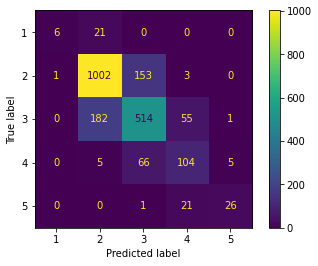

In [42]:
t1 = time.time()
y_pred = pipe.predict(X_test)
t2 = time.time()
print(f"Prediction time: {t2 - t1}")

print(accuracy_score(y_pred,y_test))
print(macro_averaged_mean_absolute_error(y_pred,y_test))
print(classification_report(y_test,y_pred,digits = 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

#calcola tutti gli alberi e li stampa in un file chiamato out.txt
#pipe['classification'].get_booster().dump_model("out.txt")

In [81]:
#CROSS VALIDATION
pipe = Pipeline([
         
         #('normalization',StandardScaler()),
         #('feature_sel',SelectKBest(score_func=f_classif, k=28)),
         #('feature_sel',SelectFromModel(OrdinalClassifier(DecisionTreeClassifier(max_depth=3)))),
         #('feature_sel',VarianceThreshold(threshold= 0.1)),
         #('feature_sel',RFECV(estimator=XGBClassifier())),
         #('feature_sel', ExtraTreesClassifier(n_estimators=10)), 
         #SequentialFeatureSelector(estimator=XGBClassifier(), n_features_to_select = 15, cv =10, direction ='backward'),
  
         #('sampling', SMOTE()),
         #('sampling', RandomOverSampler()),
         #('feature_sel',RFE(estimator=XGBClassifier(), n_features_to_select=30)),
         #('classification', LogisticRegression(C=100,solver='newton-cg'))
         #('classification',RandomForestClassifier(max_features=17, min_samples_split=3, max_depth=90))
         
         #('classification',RandomForestClassifier( max_features=17,  min_samples_split=3))
         #('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance"))
         #('classification', XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8))
         #('classification', BernoulliNB()), 
         #('classification', LogisticRegression(solver='newton-cg'))
         #('classification', svm.SVC())
         #('classification', svm.SVC(kernel= 'linear',C=0.7,gamma='auto'))
         #('classification',BaggingClassifier(base_estimator=svm.SVC(kernel= 'linear',C=0.75,gamma='auto',probability=False),n_jobs=-1))
         #('classification', OrdinalClassifier(DecisionTreeClassifier(max_depth=3))),
         ('classification', OrdinalClassifier(DecisionTreeClassifier(max_depth=3)))
         #('classification', DecisionTreeClassifier())
         #('classification', DecisionTreeClassifier(max_depth=2, criterion='gini', min_samples_leaf=20))

    ])

mamae_scorer = make_scorer(macro_averaged_mean_absolute_error, greater_is_better=True)
balacc_scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'prec_weighted': 'precision_weighted',
           'rec_macro': 'recall_macro',
           'rec_weighted': 'recall_weighted',
           'f1_macro': 'f1_macro',
           'f1_weighted': 'f1_weighted',
           'mae': 'neg_mean_absolute_error',
           'rmse': 'neg_root_mean_squared_error',
           'mamae': mamae_scorer,
           'balacc': balacc_scorer}

scores = cross_validate(pipe, X, y, scoring=scoring, cv=StratifiedKFold(10), return_train_score=True, return_estimator = True)
print(scores.keys())
print(f"Accuracy in each fold: {scores['test_acc']}")
print(f"Average Accuracy: {scores['test_acc'].mean().round(3)}")
print(f"Precision macro: {scores['test_prec_macro'].mean().round(3)}")
#print(f"Avg Precision: {scores['test_prec_weighted'].mean().round(3)}")
print(f"Recall macro: {scores['test_rec_macro'].mean().round(3)}")
#print(f"Avg recall: {scores['test_rec_weighted'].mean().round(3)}")
print(f"F1 score macro: {scores['test_f1_macro'].mean().round(3)}")
#print(f"Avg F1: {scores['test_f1_weighted'].mean().round(3)}")
print(f"Mean Absolute Error: {scores['test_mae'].mean().round(3)}")
print(f"Root Mean Squared Error: {scores['test_rmse'].mean().round(3)}")
print(f"Macro averaged mean absolute error: {scores['test_mamae'].mean().round(3)}")
print(f"Macro averaged mean absolute error: {scores['test_mamae']}")
print(f"Balanced accuracy: {scores['test_balacc'].mean().round(3)}")

"""for i in range(10):
  print("Selected features")
  filter = scores['estimator'][i]['feature_sel'].get_support()
  features = np.array(X.columns)
  print(f"Fold {i}: {features[filter]}")"""



dict_keys(['fit_time', 'score_time', 'estimator', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_prec_weighted', 'train_prec_weighted', 'test_rec_macro', 'train_rec_macro', 'test_rec_weighted', 'train_rec_weighted', 'test_f1_macro', 'train_f1_macro', 'test_f1_weighted', 'train_f1_weighted', 'test_mae', 'train_mae', 'test_rmse', 'train_rmse', 'test_mamae', 'train_mamae', 'test_balacc', 'train_balacc'])
Accuracy in each fold: [nan nan nan nan nan nan nan nan nan nan]
Average Accuracy: nan
Precision macro: nan
Recall macro: nan
F1 score macro: nan
Mean Absolute Error: nan
Root Mean Squared Error: nan
Macro averaged mean absolute error: nan
Macro averaged mean absolute error: [nan nan nan nan nan nan nan nan nan nan]
Balanced accuracy: nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py", line 217, in _fit
    **fit_params_steps[name],
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py",

'for i in range(10):\n  print("Selected features")\n  filter = scores[\'estimator\'][i][\'feature_sel\'].get_support()\n  features = np.array(X.columns)\n  print(f"Fold {i}: {features[filter]}")'

##Weka cfs+SubSetEval

In [ ]:
!pip install javabridge

!pip install python-weka-wrapper3

import weka.core.jvm as jvm
jvm.start()

     |████████████████████████████████| 1.3 MB 27.3 MB/s 
  Created wheel for javabridge: filename=javabridge-1.0.19-cp37-cp37m-linux_x86_64.whl size=1636714 sha256=0006b9b55c529cc1291b3374ae86e799e437af8cd15ea2cac1c4fabbe28550c1
  Stored in directory: /root/.cache/pip/wheels/8b/5e/7f/e1dd610613dcde4a4ed2974b4208ba90247a2dfc9add216c59
Successfully built javabridge
     |████████████████████████████████| 14.4 MB 17.1 MB/s 
     |████████████████████████████████| 1.3 MB 40.8 MB/s 
  Created wheel for python-weka-wrapper3: filename=python_weka_wrapper3-0.2.7-py3-none-any.whl size=12989631 sha256=20a5aa79314bd12c1f8d2ade9236f521634a0cb3d0f2d72819f6d680c1258b96
  Stored in directory: /root/.cache/pip/wheels/72/3a/e8/c7599e834e6c9610a3be9ecb0c158eab1b7548025e4d24b3c3
  Created wheel for python-javabridge: filename=python_javabridge-4.0.3-cp37-cp37m-linux_x86_64.whl size=1628171 sha256=894d64d368253dbf818d8ecd940a5ed386263ccf7111860a57c36f8ebf550623
  Stored in directory: /root/.cache/pip/whe

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/usr/local/lib/python3.7/dist-packages/javabridge/jars/rhino-1.7R4.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/runnablequeue.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/cpython.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/python-weka-wrapper.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [ ]:
#creo i fold e li salvo in delle liste: X_train_base, X_test_base, Y_train_base, Y_test_base
skf = StratifiedKFold(10)

X_train_base=[]
X_test_base=[]
Y_train_base=[]
Y_test_base=[]

for train_index, test_index in skf.split(X,y):

    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_base.append(X_train)
    X_test_base.append(X_test)
    Y_train_base.append(Y_train)
    Y_test_base.append(Y_test)

#print(X_train_base[0])
#print(Y_train_base[0])
#print(X_train_base[1])
#print(Y_train_base[1])

In [ ]:
X_train_base_c = X_train_base.copy()
Y_train_base_c = Y_train_base.copy()

In [ ]:
#converto i df in numpy array in modo da poter essere "letti" da weka
for i in range(10):  
  X_train_base_c[i] = X_train_base_c[i].to_numpy()
  Y_train_base_c[i] = Y_train_base_c[i].to_numpy()

In [ ]:
from weka.core.dataset import create_instances_from_matrices
#creo fold: una lista di dataset
fold = []

for i in range(10):
  fold.append(create_instances_from_matrices(X_train_base_c[i],Y_train_base_c[i]))

In [ ]:
#settiamo la classe in tutti i fold
for i in range(10):
    fold[i].class_is_last()

In [ ]:
#Perform the attribute selection e per ogni fold elimino le features non necessarie, quindi avrò per ogni fold solo le features selezionate
from weka.attribute_selection import ASSearch, ASEvaluation, AttributeSelection
search = ASSearch(classname="weka.attributeSelection.BestFirst", options=["-D", "1", "-N", ""])
evaluator = ASEvaluation(classname="weka.attributeSelection.CfsSubsetEval", options=["-P", "1", "-E", "1"])
attsel = AttributeSelection()
attsel.search(search)
attsel.evaluator(evaluator)

for i in range(10):
  attsel.select_attributes(fold[i])
  print("# attributes: " + str(attsel.number_attributes_selected))
  print("attributes: " + str(attsel.selected_attributes))
  selected_attributes = np.delete(attsel.selected_attributes, attsel.selected_attributes.size-1)
  X_train_base[i]= X_train_base[i].iloc[:,selected_attributes]
  X_test_base[i]= X_test_base[i].iloc[:,selected_attributes]
#print("result string:\n" + attsel.results_string)

# attributes: 14
attributes: [ 0 10 12 13 21 26 29 30 31 32 33 36 38 42 47]
# attributes: 13
attributes: [10 13 16 26 29 30 31 32 33 36 38 40 42 47]
# attributes: 15
attributes: [ 0 10 11 12 13 26 29 30 31 32 33 36 38 41 42 47]
# attributes: 15
attributes: [ 0  2 10 12 13 26 29 30 31 32 33 36 38 41 42 47]
# attributes: 14
attributes: [ 0 10 11 12 13 26 29 30 31 32 33 36 38 42 47]
# attributes: 13
attributes: [ 0 10 13 16 17 26 29 30 31 32 33 36 42 47]
# attributes: 13
attributes: [ 0 10 12 13 26 29 30 31 32 33 36 38 42 47]
# attributes: 13
attributes: [ 0 10 12 13 26 29 30 31 32 33 36 38 42 47]
# attributes: 13
attributes: [ 0 10 11 12 13 26 29 30 31 32 33 36 42 47]
# attributes: 12
attributes: [ 0 10 13 26 29 30 31 32 33 36 38 42 47]


In [ ]:
import pickle
model = svm.SVC(kernel= 'linear',C=0.7,gamma='auto')

model.fit(X_train_base[7],Y_train_base[7])

filename = 'model_gk2.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#Eseguo la classificazione per ogni fold
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import time, datetime, date
import time
accuracies = []
precisions = []
recalls = []
f1s = []
maes = []
rmse = []
build_times = []
pred_times = []
mamae = []

#model = KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance")
#model = XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8)
#model = RandomForestClassifier(min_samples_split=3)
#model = BernoulliNB()
model = svm.SVC(kernel= 'linear',C=0.7,gamma='auto')

for i in range(10):
  t1 = time.time()
  model.fit(X_train_base[i],Y_train_base[i])
  #model.fit(X_train_base_resampled[i],Y_train_base_resampled[i])
  t2 = time.time()
  build_times.append(t2-t1)

  t3 = time.time()
  y_pred = model.predict(X_test_base[i])
  t4 = time.time()
  pred_times.append(t4-t3)

  accuracies.append(accuracy_score(y_pred,Y_test_base[i]))
  precisions.append(precision_score(y_pred,Y_test_base[i],average='macro'))
  recalls.append(recall_score(y_pred,Y_test_base[i],average='macro'))
  f1s.append(f1_score(y_pred,Y_test_base[i],average='macro'))
  maes.append(mean_absolute_error(y_pred,Y_test_base[i]))
  rmse.append(mean_squared_error(y_pred,Y_test_base[i],squared=False))
  mamae.append(macro_averaged_mean_absolute_error(y_pred,Y_test_base[i]))
  print(accuracies[i])
  #print(accuracy_score(y_pred,Y_test_base[i]))
  #print(classification_report(Y_test_base[i],y_pred,digits = 3))

print(f"Average accuracy: {np.mean(accuracies).round(3)}")
print(f"Average precision: {np.mean(precisions).round(3)}")
print(f"Average recall: {np.mean(recalls).round(3)}")
print(f"Average f score: {np.mean(f1s).round(3)}")
print(f"Average mean absolute error: {np.mean(maes).round(3)}")
print(f"Average root mean squared error: {np.mean(rmse).round(3)}")
print(f"Average build time: {np.mean(build_times).round(3)}")
print(f"Average prediction time: {np.mean(pred_times).round(3)}")
print(f"MACRO Average mean absolute error: {np.mean(mamae).round(3)}")

0.8
0.8857142857142857
0.7428571428571429
0.7428571428571429
0.8857142857142857
0.8571428571428571
0.9142857142857143
0.9142857142857143
0.8571428571428571
0.8823529411764706
Average accuracy: 0.848
Average precision: 0.772
Average recall: 0.865
Average f score: 0.799
Average mean absolute error: 0.152
Average root mean squared error: 0.382
Average build time: 0.004
Average prediction time: 0.002
MACRO Average mean absolute error: 0.135


In [ ]:
#SAVE THE MODEL
import pickle

filename = 'model_gk.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#Eseguo la classificazione per ogni fold. LOGISTIC REGRESSION
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import time, datetime, date
import time
accuracies = []
precisions = []
recalls = []
f1s = []
maes = []
rmse = []
build_times = []
pred_times = []

#model = KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance")
#model = XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8)
#model = RandomForestClassifier(max_features=13, min_samples_split=3)
#model = BernoulliNB()
model = Pipeline([
                  ('normalization',StandardScaler()),
                  ('classification', LogisticRegression(solver='newton-cg'))
])

for i in range(10):
  t1 = time.time()
  #model.fit(X_train_base[i],Y_train_base[i])
  model.fit(X_train_base_resampled[i],Y_train_base_resampled[i])
  t2 = time.time()
  build_times.append(t2-t1)

  t3 = time.time()
  y_pred = model.predict(X_test_base[i])
  t4 = time.time()
  pred_times.append(t4-t3)

  accuracies.append(accuracy_score(y_pred,Y_test_base[i]))
  precisions.append(precision_score(y_pred,Y_test_base[i],average='macro'))
  recalls.append(recall_score(y_pred,Y_test_base[i],average='macro'))
  f1s.append(f1_score(y_pred,Y_test_base[i],average='macro'))
  maes.append(mean_absolute_error(y_pred,Y_test_base[i]))
  rmse.append(mean_squared_error(y_pred,Y_test_base[i],squared=False))
  mamae.append(macro_averaged_mean_absolute_error(y_pred,Y_test_base[i]))
  print(accuracies[i])
  #print(accuracy_score(y_pred,Y_test_base[i]))
  #print(classification_report(Y_test_base[i],y_pred,digits = 3))

print(f"Average accuracy: {np.mean(accuracies).round(3)}")
print(f"Average precision: {np.mean(precisions).round(3)}")
print(f"Average recall: {np.mean(recalls).round(3)}")
print(f"Average f score: {np.mean(f1s).round(3)}")
print(f"Average mean absolute error: {np.mean(maes).round(3)}")
print(f"Average root mean squared error: {np.mean(rmse).round(3)}")
print(f"Average build time: {np.mean(build_times).round(3)}")
print(f"Average prediction time: {np.mean(pred_times).round(3)}")
print(f"MACRO Average mean absolute error: {np.mean(mamae).round(3)}")

0.8285714285714286
0.8857142857142857
0.8
0.7714285714285715
0.9428571428571428
0.8571428571428571
0.9142857142857143
0.9428571428571428
0.9142857142857143
0.8529411764705882
Average accuracy: 0.871
Average precision: 0.857
Average recall: 0.853
Average f score: 0.848
Average mean absolute error: 0.132
Average root mean squared error: 0.361
Average build time: 0.059
Average prediction time: 0.003
MACRO Average mean absolute error: 0.287


In [ ]:
#REBALANCING
copiax = X_train_base[0].copy()
copiay = Y_train_base[0].copy()

X_train_base_resampled = []
Y_train_base_resampled = []

for i in range(10):
  x_temp, y_temp = RandomOverSampler().fit_resample(X_train_base[i],Y_train_base[i])
  X_train_base_resampled.append(x_temp)
  Y_train_base_resampled.append(y_temp)

##Hyperparameters tuning

In [ ]:
#HYPERPARAMETER TUNING XGBClassifier
from sklearn.model_selection import GridSearchCV

model = XGBClassifier(max_depth=5,min_child_weight=3,gamma=0.4)
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

parameters2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

parameters3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

grid = GridSearchCV(model, parameters3, cv=10, scoring="neg_mean_absolute_error")

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

In [ ]:
#HYPERPARAMETER TUNING KNN
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier(n_neighbors= 10)
parameters = {
 'leaf_size':[1,10,15,20,30,40,50],
 'n_neighbors': [5,7,9,10,11,13,15,20,21,22],
 'weights' : ['uniform','distance'],
 'p':(1,2),
 'metric' : ['minkowski','euclidean','manhattan']
}

grid = GridSearchCV(model, parameters, cv=10, scoring = 'neg_mean_absolute_error')

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

the best parameters are 
 {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 21, 'p': 1, 'weights': 'distance'}


In [ ]:
#HYPERPARAMETER TUNING RANDOM FOREST
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
parameters = {
 'n_estimators':[100,200,300],
 'max_depth': [80, 90, 100, 110],
 'max_features' : ['auto', 'sqrt'],
 'min_samples_leaf': [1,3,5],
 'min_samples_split' : [3,5,8,10]
}

grid = GridSearchCV(model, parameters, cv=10, scoring = 'neg_mean_absolute_error')

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

the best parameters are 
 {'max_depth': 90, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}


In [ ]:
#HYPERPARAMETER TUNING LOGISTIC REGRESSION
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
parameters = {
 'solver':['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['none', 'l1', 'l2', 'elasticnet'],
 'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

grid = GridSearchCV(model, parameters, cv=10, scoring = 'neg_mean_absolute_error')

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore

the best parameters are 
 {'C': 1e-05, 'penalty': 'none', 'solver': 'newton-cg'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


In [65]:
#HYPERPARAMETER TUNING DECISION TREE
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
parameters = {

    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]

}

grid = GridSearchCV(model, parameters, cv=10, scoring = mamae_scorer)

grid.fit(X_train,y_train)
print("the best parameters are \n {}".format(grid.best_params_))

the best parameters are 
 {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 20}


## Student t-test

In [ ]:
from sklearn.preprocessing import StandardScaler
#CROSS VALIDATION
pipe = Pipeline([
         
         #('normalization',StandardScaler()),
         #('feature_sel',SelectKBest(score_func=f_classif, k=28)),
         ('feature_sel',SelectFromModel(RandomForestClassifier( max_features=16,  min_samples_split=3))),
         #('sampling', SMOTE()),
         #('sampling', RandomOverSampler()),
         
         ('classification',RandomForestClassifier( max_features=16,  min_samples_split=3))
         #('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance"))
         #('classification', XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8))
         #('classification', BernoulliNB()), 
         #('classification', LogisticRegression(solver='newton-cg'))
         #('classification', svm.SVC())
         #('classification', svm.SVC(kernel= 'linear',C=0.7,gamma='auto'))
         #('classification',BaggingClassifier(base_estimator=svm.SVC(kernel= 'linear',C=0.75,gamma='auto',probability=False),n_jobs=-1))
    ])

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'prec_weighted': 'precision_weighted',
           'rec_macro': 'recall_macro',
           'rec_weighted': 'recall_weighted',
           'f1_macro': 'f1_macro',
           'f1_weighted': 'f1_weighted',
           'mae': 'neg_mean_absolute_error',
           'rmse': 'neg_root_mean_squared_error'}
scores = cross_validate(pipe, X, y, scoring=scoring, cv=StratifiedKFold(10), return_train_score=True, return_estimator = True)
print(scores.keys())
print(f"Accuracy in each fold: {scores['test_acc']}")
print(f"Average Accuracy: {scores['test_acc'].mean().round(3)}")
print(f"Precision macro: {scores['test_prec_macro'].mean().round(3)}")
#print(f"Avg Precision: {scores['test_prec_weighted'].mean().round(3)}")
print(f"Recall macro: {scores['test_rec_macro'].mean().round(3)}")
#print(f"Avg recall: {scores['test_rec_weighted'].mean().round(3)}")
print(f"F1 score macro: {scores['test_f1_macro'].mean().round(3)}")
#print(f"Avg F1: {scores['test_f1_weighted'].mean().round(3)}")
print(f"Mean Absolute Error: {scores['test_mae'].mean().round(3)}")
print(f"Root Mean Squared Error: {scores['test_rmse'].mean().round(3)}")

for i in range(10):
  print("Selected features")
  filter = scores['estimator'][i]['feature_sel'].get_support()
  features = np.array(X.columns)
  print(f"Fold {i}: {features[filter]}")



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

dict_keys(['fit_time', 'score_time', 'estimator', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_prec_weighted', 'train_prec_weighted', 'test_rec_macro', 'train_rec_macro', 'test_rec_weighted', 'train_rec_weighted', 'test_f1_macro', 'train_f1_macro', 'test_f1_weighted', 'train_f1_weighted', 'test_mae', 'train_mae', 'test_rmse', 'train_rmse'])
Accuracy in each fold: [0.7867036  0.78947368 0.77977839 0.7867036  0.73822715 0.78393352
 0.81440443 0.79224377 0.8365651  0.78808864]
Average Accuracy: 0.79
Precision macro: 0.691
Recall macro: 0.563
F1 score macro: 0.588
Mean Absolute Error: -0.213
Root Mean Squared Error: -0.466
Selected features
Fold 0: ['goals' 'assists' 'shots_ontarget' 'touches' 'passes_acc' 'passes_inacc'
 'grduels_w' 'aerials_w' 'poss_lost' 'clearances' 'betweenness_centrality'
 'closeness_centrality' 'flow_centrality' 'flow_success'
 'betweenness2goals' 'win' 'lost' 'minutesPlayed' 'starter']
Selected features
Fold 1: ['goals' 'assists' 'shots_ont

In [ ]:
from sklearn.preprocessing import StandardScaler
#CROSS VALIDATION
pipe = Pipeline([
         
         #('normalization',StandardScaler()),
         ('feature_sel',SelectKBest(score_func=f_classif, k=28)),
         #('feature_sel',SelectFromModel(RandomForestClassifier( max_features=16,  min_samples_split=3))),
         #('sampling', SMOTE()),
         #('sampling', RandomOverSampler()),
         #('classification', LogisticRegression(C=100,solver='newton-cg'))
         
         #('classification',RandomForestClassifier( max_features=16,  min_samples_split=3))
         #('classification', KNeighborsClassifier(n_neighbors= 21,leaf_size=1,p=1,weights="distance"))
         #('classification', XGBClassifier(max_depth=5, min_child_weight=3,colsample_bytree=0.9,subsample=0.8))
         #('classification', BernoulliNB()), 
         #('classification', LogisticRegression(solver='newton-cg'))
         #('classification', svm.SVC())
         ('classification', svm.SVC(kernel= 'linear',C=0.7,gamma='auto'))
         #('classification',BaggingClassifier(base_estimator=svm.SVC(kernel= 'linear',C=0.75,gamma='auto',probability=False),n_jobs=-1))
    ])

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'prec_weighted': 'precision_weighted',
           'rec_macro': 'recall_macro',
           'rec_weighted': 'recall_weighted',
           'f1_macro': 'f1_macro',
           'f1_weighted': 'f1_weighted',
           'mae': 'neg_mean_absolute_error',
           'rmse': 'neg_root_mean_squared_error'}
scores = cross_validate(pipe, X, y, scoring=scoring, cv=StratifiedKFold(10), return_train_score=True, return_estimator = True)
print(scores.keys())
print(f"Accuracy in each fold: {scores['test_acc']}")
print(f"Average Accuracy: {scores['test_acc'].mean().round(3)}")
print(f"Precision macro: {scores['test_prec_macro'].mean().round(3)}")
#print(f"Avg Precision: {scores['test_prec_weighted'].mean().round(3)}")
print(f"Recall macro: {scores['test_rec_macro'].mean().round(3)}")
#print(f"Avg recall: {scores['test_rec_weighted'].mean().round(3)}")
print(f"F1 score macro: {scores['test_f1_macro'].mean().round(3)}")
#print(f"Avg F1: {scores['test_f1_weighted'].mean().round(3)}")
print(f"Mean Absolute Error: {scores['test_mae'].mean().round(3)}")
print(f"Root Mean Squared Error: {scores['test_rmse'].mean().round(3)}")

for i in range(10):
  print("Selected features")
  filter = scores['estimator'][i]['feature_sel'].get_support()
  features = np.array(X.columns)
  print(f"Fold {i}: {features[filter]}")



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['fit_time', 'score_time', 'estimator', 'test_acc', 'train_acc', 'test_prec_macro', 'train_prec_macro', 'test_prec_weighted', 'train_prec_weighted', 'test_rec_macro', 'train_rec_macro', 'test_rec_weighted', 'train_rec_weighted', 'test_f1_macro', 'train_f1_macro', 'test_f1_weighted', 'train_f1_weighted', 'test_mae', 'train_mae', 'test_rmse', 'train_rmse'])
Accuracy in each fold: [0.82409972 0.79778393 0.7867036  0.79778393 0.7867036  0.82963989
 0.83518006 0.82825485 0.8434903  0.81855956]
Average Accuracy: 0.815
Precision macro: 0.807
Recall macro: 0.633
F1 score macro: 0.673
Mean Absolute Error: -0.186
Root Mean Squared Error: -0.434
Selected features
Fold 0: ['goals' 'assists' 'shots_ontarget' 'chances2score' 'drib_success'
 'touches' 'passes_acc' 'passes_inacc' 'lballs_acc' 'lballs_inacc'
 'grduels_w' 'aerials_w' 'poss_lost' 'clearances' 'interceptions'
 'tackles' 'rcards' 'countattack' 'betweenness_centrality'
 'closeness_centrality' 'flow_centrality' 'flow_success'
 'bet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<function matplotlib.pyplot.show>

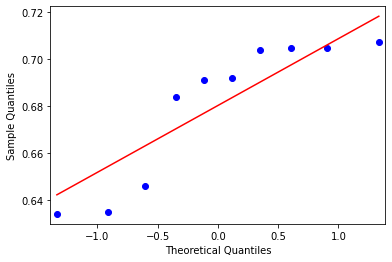

In [ ]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

qqplot(scores['test_f1_macro'],line = 's')
pyplot.show

In [ ]:
#SHAPIRO WILK TEST
from scipy.stats import shapiro

stat, p = shapiro(scores['test_acc'])
#stat, p = shapiro(scores['test_f1_macro'])
#stat, p = shapiro(scores['test_mae'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.916, p=0.325
Sample looks Gaussian (fail to reject H0)


In [ ]:
a_acc = scores['test_acc']
#if NOT Gaussian:
a_f1 = np.sqrt(scores['test_f1_macro'])

#a_f1 = scores['test_f1_macro']
a_mae = scores['test_mae']

In [ ]:
b_acc = scores['test_acc']
b_f1 = scores['test_f1_macro']
b_mae = scores['test_mae']

In [ ]:
from scipy.stats import ttest_rel

# Python paired sample t-test
print(f"accuracy: {ttest_rel(a_acc, b_acc)}")
print(f"f score: {ttest_rel(a_f1, b_f1)}")
print(f"MAE: {ttest_rel(a_mae, b_mae)}")

accuracy: Ttest_relResult(statistic=1.97066740354441, pvalue=0.0802559142897024)
f score: Ttest_relResult(statistic=18.957985878524777, pvalue=1.4547600977225277e-08)
MAE: Ttest_relResult(statistic=1.9193450595471568, pvalue=0.08714787243447174)
